# 1 Corpus beschaffen importieren

In [69]:
import create_record as cr
import pandas as pd

corpus = pd.Series({}, dtype="object")

In [70]:
TafsirId = 4
Sura = 1
Aya = 6

temp = cr.altafsir_extractor(TafsirId, Sura, Aya)
temp.collect_data()
corpus["Text"] = temp.Text
temp.write_data()

Writing to 4_1_6.txt
Saved file successfully


# 2 Preprocessing
## 2.1 Normalizing data

In [71]:
from camel_tools.utils.normalize import normalize_unicode
from camel_tools.utils.dediac import dediac_ar


def reduce_to_archarset(text):
    import re
    # Remove non-arabic characters
    nonarab_chars = '[^\u0621-\u064A ]'
    text = re.sub(nonarab_chars, ' ', text)
    return text

def remove_aya(text):
    import re
    # Remove cited aya content
    aya = '\{(.*?)\}'
    text = re.sub(aya, '', text)
    return text

def remove_ref(text):
    import re
    # Remove reference to other ayas
    ref = '\[(.*?)\]'
    text = re.sub(ref, '', text)
    return text

def remove_eulogies(text):
    import re
    with open("./assets/eulogies.txt", encoding="utf-8") as f:
        eulogies = f.read().splitlines()
    for eulogy in eulogies:
        text = re.sub(eulogy, '', text)
    return text


## normalize
def normalizer(string):
    string_normalized = normalize_unicode(string)
    
    # remove diacritica
    string_normalized = dediac_ar(string_normalized)

    string_normalized = remove_ref(string_normalized)
    string_normalized = remove_aya(string_normalized)
    string_normalized = remove_eulogies(string_normalized)
    
    #reduce to arabic charset
    string_normalized = reduce_to_archarset(string_normalized)
    return string_normalized


corpus["TextNormalized"] = normalizer(corpus["Text"])

In [72]:
corpus["TextNormalized"]

'أما قوله جل جلاله   فاعلم أنه عبارة عن طلب الهداية  ولتحصيل الهداية طريقان  أحدهما  طلب المعرفة بالدليل والحجة  والثاني  بتصفية الباطن والرياضة  أما طرق الاستدلال فإنها غير متناهية لأنه لا ذرة من ذرات العالم الأعلى والأسفل إلا وتلك الذرة شاهدة بكمال إلهيته  وبعزة عزته  وبجلال صمديته  كما قيل وفي كل شيء له آية   تدل على أنه واحدوتقريره  أن أجسام العالم متساوية في ماهية الجسمية  ومختلفة في الصفات  وهي الألوان والأمكنة والأحوال  ويستحيل أن يكون اختصاص كل جسم بصفته المعينة لأجل الجسمية أو لوازم الجسمية  وإلا لزم حصول الاستواء  فوجب أن يكون ذلك لتخصيص مخصص وتدبير مدبر  وذلك المخصص إن كان جسما عاد الكلام فيه  وإن لم يكن جسما فهو المطلوب  ثم ذلك الموجود إن لم يكن حيا عالما قادرا  بل كان تأثيره بالفيض والطبع عاد الإلزام في وجوب الاستواء  وإن كان حيا عالما قادرا فهو المطلوب  إذا عرفت هذا فقد ظهر أن كل واحد من ذرات السموات والأرض شاهد صادق  ومخبر ناطق  بوجود الإله القادر الحكيم العليم  وكان الشيخ الإمام الوالد ضياء الدين عمر رحمه  يقول  إن لله  في كل جوهر فرد أنواعا غير متناهية من الدلائل الدال

## 2.2 Tokenization

In [73]:
from camel_tools.tokenizers.word import simple_word_tokenize

corpus["Tokenized"] = simple_word_tokenize(corpus["TextNormalized"])

## 2.3 Disambiguation

In [74]:
from camel_tools.disambig.mle import MLEDisambiguator

# instantiate the Maximum Likelihood Disambiguator
mle = MLEDisambiguator.pretrained()

# The disambiguator expects pre-tokenized text
corpus["disambig"] = mle.disambiguate(corpus["Tokenized"])
# diacritized = [d.analyses[0].analysis['diac'] for d in disambig]

In [75]:
reducable = [dediac_ar(d.analyses[0].analysis["lex"]) for d in corpus["disambig"][:]]

In [76]:
reducable

['أما',
 'قول',
 'جل',
 'جلالة',
 'علم',
 'أن',
 'عبارة',
 'عن',
 'طلب',
 'هداية',
 'تحصيل',
 'هداية',
 'طريق',
 'أحد',
 'طلب',
 'معرفة',
 'دليل',
 'حجة',
 'ثاني',
 'تصفية',
 'باطن',
 'رياضة',
 'أما',
 'طريق',
 'ٱستدلال',
 'إن',
 'غير',
 'متناهي',
 'أن',
 'لا',
 'ذرة',
 'من',
 'ذرة',
 'عالم',
 'أعلى',
 'أسفل',
 'إلا',
 'ذلك',
 'ذرة',
 'شاهد',
 'كمال',
 'إلهي',
 'عزة',
 'عزا',
 'جلال',
 'صمديته',
 'كما',
 'قال',
 'في',
 'كل',
 'شيء',
 'ل',
 'آية',
 'دل',
 'على',
 'أن',
 'واحدوتقريره',
 'أن',
 'جسم',
 'عالم',
 'متساوي',
 'في',
 'ماهية',
 'جسمي',
 'مختلف',
 'في',
 'صفة',
 'هي',
 'لون',
 'مكان',
 'حال',
 'ٱستحال',
 'أن',
 'كان',
 'ٱختصاص',
 'كل',
 'جسم',
 'صفة',
 'معين',
 'أجل',
 'جسمي',
 'أو',
 'لازمة',
 'جسمي',
 'إلا',
 'لزم',
 'حصول',
 'ٱستواء',
 'وجب',
 'أن',
 'كان',
 'ذلك',
 'تخصيص',
 'مخصص',
 'تدبير',
 'مدبر',
 'ذلك',
 'مخصص',
 'إن',
 'كان',
 'جسم',
 'عاد',
 'كلام',
 'في',
 'إن',
 'لم',
 'كان',
 'جسم',
 'هو',
 'مطلوب',
 'ثم',
 'ذلك',
 'موجود',
 'إن',
 'لم',
 'كان',
 'حي',
 'عالم',
 '

In [77]:
def stopwords(token_list, stopwords_list):

    token_list_filtered = []
    words_removed = []
    for token in token_list:
        if token not in stopwords_list:
            token_list_filtered.append(token)
        if token in stopwords_list:
            words_removed.append(token)

    return token_list_filtered, words_removed

In [78]:
with open("./assets/stopwords_nltk.txt", "r", encoding="utf-8") as sf:
    stopwords_nltk = sf.read()
with open("./assets/stopwords_extra.txt", "r", encoding="utf-8") as sf:
    stopwords_extra = sf.read()

In [79]:
stpws = stopwords_nltk + " " + stopwords_extra

In [80]:
stwkeep = stopwords(reducable, stpws)[0]
stwrem = stopwords(reducable, stpws)[1]


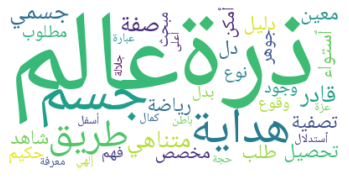

In [81]:
from collections import Counter

from wordcloud import WordCloud          # pip install wordcloud
import matplotlib.pyplot as plt          
# -- Arabic text dependencies
from arabic_reshaper import reshape      # pip install arabic-reshaper
from bidi.algorithm import get_display   # pip install python-bidi

rtl = lambda w: get_display(reshape(f'{w}'))

COUNTS = Counter(stwkeep)
counts = {k:v for k, v in COUNTS.most_common(40)}
counts_rtl = {rtl(k):v for k, v in COUNTS.most_common(40)}

# Output to file
with open(f"./output/freqs_{TafsirId}_{Sura}_{Aya}.csv", 'w', encoding="utf-8") as f:
    for key in counts.keys():
        f.write("%s, %s\n" % (key, counts[key]))


# output to graphics and file
font_file = './assets/NotoNaskhArabic-Regular.ttf'
wordcloud = WordCloud(font_path=font_file, background_color="white").generate_from_frequencies(counts_rtl)
wordcloud.to_file(f"./output/wc_{TafsirId}_{Sura}_{Aya}.png")
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
